In [196]:
from matplotlib import pyplot as plt
import numpy as np
from scipy.integrate import solve_bvp
from scipy.optimize import root

## General class
Here we make a class that accepts a function that represents the differential equation in terms of the state and costate.
We also pass in a value for the optimal control.


In [197]:
class Control_Solver_Plotter:
    def __init__(self):
        self.t = None
        self.x = None
        self.u = None
        self.ode = None
        self.u_func = None
        self.bc = None

    def define_evolution(self,ode,bc):
        self.ode = ode
        self.bc = bc
        return self

    def define_control_function(self,u_func):
        self.u_func = u_func
        return self

    def solve_problem(self, t0, tf=None, n_points=100, x_guess=None):
        param = False
        if tf is None:
            tf = 1
            param = True
        self.tf = tf
        
        self.t = np.linspace(t0, tf, n_points + 1)
        
        # Initialize x_guess if not provided
        if x_guess is None:
            x_guess = np.ones((2,n_points + 1))
        
        # Solve the boundary value problem
        if param:
            param_guess = np.array([1])  # Example parameter guess
            sol = solve_bvp(self.ode, self.bc, self.t, x_guess, param_guess)
        else:
            sol = solve_bvp(self.ode, self.bc, self.t, x_guess)
        
        # Assign solution to class attributes
        self.t = sol.x
        self.x = sol.y
        self.u = self.u_func(sol.y)
        
        return self

    def plot_solution(self,color, subplot = None, ax0=None, ax1=None, labels = None):
        
        
        ax0.plot(self.t,self.x[0],color,label = f'$\\alpha$ = {labels[0]}, $\\beta$={labels[1]}')
        ax1.plot(self.t,self.u,color,label = f'$\\alpha$ = {labels[0]}, $\\beta$={labels[1]}')
        ax0.set_title('Pollution: $x(t)$')
        ax0.set_xlabel("$t$")
        ax0.set_xlim([0,5])
        ax0.legend()
        ax1.set_title(r'Tax: $\tilde{u}(t)$')
        ax1.set_xlabel("$t$")
        ax1.set_xlim([0,5])
        ax1.legend()

    def plot_price_quantity(self):
        plt.figure(figsize=(4,3.5))
        plt.plot(self.t, 1+self.u/2, label="Price")
        plt.plot(self.t, 1-self.u/2, label="Quantity")
        plt.xlim([0,5])
        plt.xlabel("time")
        plt.title("Price vs Quantity")
        plt.legend()
        plt.tight_layout()
        plt.savefig('SimplestProblem_price.png', dpi = 200)
        plt.show()
        

In [198]:
def PlotSimplestProblem(alpha, beta, n0, nf, t0, tf, color=None, ax0=None, ax1=None):
    a, b = 2, 1

    def u_func(x):
        def implicitFormula(u):
            return -b/2*x[1] - 2*alpha*u + 1/500*(u / ((a/b)**2 - u**2))
        return root(implicitFormula, x0=np.ones_like(x[1])*0.5).x

    def ode(t,x):
        return np.array([
            .5*(a-b*u_func(x)) - beta*x[0],
            2*x[0] + beta*x[1]
            ])
    def bc(ya,yb):
        return np.array([ya[0]-n0, yb[1]])

    plotter = Control_Solver_Plotter().define_control_function(u_func).define_evolution(ode,bc)
    plotter.solve_problem(t0,tf)
    plotter.plot_solution(ax0=ax0, ax1=ax1, labels = [alpha, beta], color=color)

In [199]:
def PlotSimplestProblem_price(alpha, beta, n0, nf, t0, tf, color=None, ax0=None, ax1=None, price=False):
    a, b = 2, 1

    def u_func(x):
        def implicitFormula(u):
            return -b/2*x[1] - 2*alpha*u + 1/500*(u / ((a/b)**2 - u**2))
        return root(implicitFormula, x0=np.ones_like(x[1])*0.5).x

    def ode(t,x):
        return np.array([
            .5*(a-b*u_func(x)) - beta*x[0],
            2*x[0] + beta*x[1]
            ])
    def bc(ya,yb):
        return np.array([ya[0]-n0, yb[1]])

    plotter = Control_Solver_Plotter().define_control_function(u_func).define_evolution(ode,bc)
    plotter.solve_problem(t0,tf)
    plotter.plot_price_quantity()

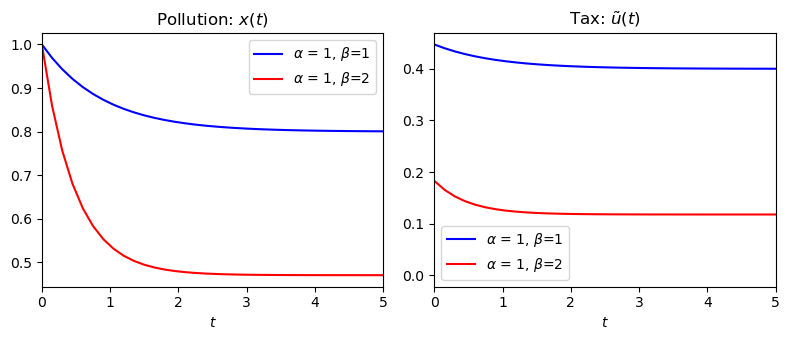

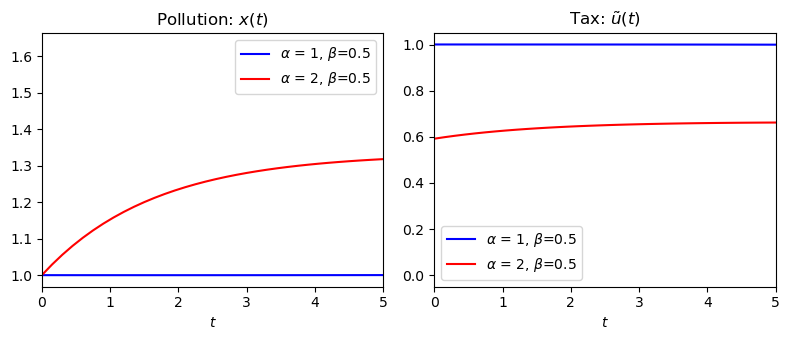

In [200]:
fig, axs = plt.subplots(1,2,figsize=(8,3.5))

colors = ['Blue', 'Red', 'Green', 'Orange', 'Magenta', 'Yellow', 'Black', 'White', 'Gray', 'Cyan']

i = 0
alpha_list = [1] #[1,10]

# Beta values should not be less than .19
# It is realistic to think pollution would not naturally dissipate in the environment
beta_list = [1,2] #[5,10]
for alph in alpha_list:
    for beta in beta_list:
        PlotSimplestProblem(alpha=alph, beta=beta, n0=1, nf=0.5, t0=0, tf=15, ax0=axs.ravel()[i%2], ax1=axs.ravel()[(i+1)%2], color=colors[int(i/2)])
        i += 2
        

# plt.suptitle("Simplest Problem - Variation in $\\beta$")
plt.tight_layout()
plt.savefig('SimplestProblem1.png', dpi = 200)
plt.show()

fig, axs = plt.subplots(1,2,figsize=(8,3.5))
i = 0
alpha_list = [1, 2] #[1,10]

# Beta values should not be less than .19
# It is realistic to think pollution would not naturally dissipate in the environment
beta_list = [.5] #[5,10]
for alph in alpha_list:
    for beta in beta_list:
        PlotSimplestProblem(alpha=alph, beta=beta, n0=1, nf=0.5, t0=0, tf=15, ax0=axs.ravel()[i%2], ax1=axs.ravel()[(i+1)%2], color=colors[int(i/2)])
        i += 2
        

# plt.suptitle("Simplest Problem - Variation in $\\alpha$")
plt.tight_layout()
plt.savefig('SimplestProblem2.png', dpi = 200)
plt.show()

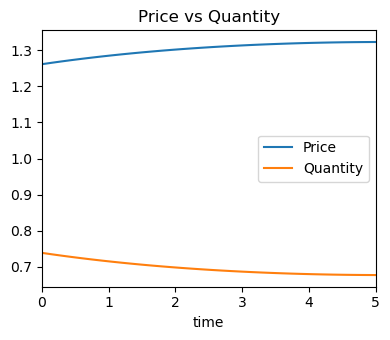

In [207]:
# Plot of price per quantity
PlotSimplestProblem_price(alpha=10, beta=.2, n0=1, nf=0.5, t0=0, tf=15, price=True, color="blue")

